In [1]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset, random_split
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.metrics import f1_score, classification_report
# import pandas as pd
# import numpy as np

# # Load data
# amplitude_df = pd.read_csv("/kaggle/input/amplifreq/all_signals.csv", header=None)
# frequency_df = pd.read_csv("/kaggle/input/amplifreq/all_frequencies.csv", header=None)

# # Step 1: Prepare amplitude input (X)
# X = amplitude_df.iloc[:, 1:].values.astype(np.float32)  # Keep time column in sync but skip it for training
# X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)  # Normalize each sample

# # Step 2: Prepare frequency labels (y)
# y_raw = frequency_df.iloc[:, 1:].values  # Skip first column only for labeling

# # Extract actual frequency values while keeping time 0s intact
# label_sets = []
# for row in y_raw:
#     freqs = [val for val in row if val not in [0, 50, 150, 250, 350, 450, 550, 650, 750, 881, 950]]  # Keep actual frequency values only
#     label_sets.append(list(set(freqs)))  # Unique labels per row

# # Multi-label binarization
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(label_sets)

# # Step 3: Tensor conversion
# X_tensor = torch.tensor(X)
# y_tensor = torch.tensor(y).float()

# # Step 4: Dataset and Dataloader
# dataset = TensorDataset(X_tensor, y_tensor)
# train_size = int(0.8 * len(dataset))
# train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64)

# # Step 5: Define model
# class FrequencyClassifier(nn.Module):
#     def __init__(self, input_size, num_labels):
#         super(FrequencyClassifier, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_size, 512),
#             nn.ReLU(),
#             nn.BatchNorm1d(512),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.BatchNorm1d(256),
#             nn.Dropout(0.3),
#             nn.Linear(256, num_labels),
#             nn.Sigmoid()  # Multi-label classification
#         )

#     def forward(self, x):
#         return self.net(x)

# # Initialize model
# model = FrequencyClassifier(X.shape[1], y.shape[1])
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Step 6: Training loop
# for epoch in range(350):
#     model.train()
#     total_loss = 0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch+1}/20, Loss: {total_loss / len(train_loader):.4f}")

# # Step 7: Evaluation
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in val_loader:
#         outputs = model(inputs)
#         preds = (outputs > 0.5).int()
#         all_preds.extend(preds.numpy())
#         all_labels.extend(labels.numpy())

# f1 = f1_score(all_labels, all_preds, average='micro')
# print(f"\nMicro F1 Score: {f1:.4f}")
# print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=[str(label) for label in mlb.classes_]))


In [2]:
# import torch
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

Epoch 1/50, Loss: 0.2488, Val Micro F1: 0.7381
Epoch 2/50, Loss: 0.0367, Val Micro F1: 0.8570
Epoch 3/50, Loss: 0.0269, Val Micro F1: 0.8793
Epoch 4/50, Loss: 0.0235, Val Micro F1: 0.8868
Epoch 5/50, Loss: 0.0216, Val Micro F1: 0.8924
Epoch 6/50, Loss: 0.0201, Val Micro F1: 0.8982
Epoch 7/50, Loss: 0.0193, Val Micro F1: 0.9034
Epoch 8/50, Loss: 0.0178, Val Micro F1: 0.9034
Epoch 9/50, Loss: 0.0167, Val Micro F1: 0.9063
Epoch 10/50, Loss: 0.0161, Val Micro F1: 0.9126
Epoch 11/50, Loss: 0.0152, Val Micro F1: 0.9129
Epoch 12/50, Loss: 0.0146, Val Micro F1: 0.9150
Epoch 13/50, Loss: 0.0139, Val Micro F1: 0.9168
Epoch 14/50, Loss: 0.0134, Val Micro F1: 0.9159
Epoch 15/50, Loss: 0.0132, Val Micro F1: 0.9194
Epoch 16/50, Loss: 0.0127, Val Micro F1: 0.9148
Epoch 17/50, Loss: 0.0123, Val Micro F1: 0.9163
Epoch 18/50, Loss: 0.0119, Val Micro F1: 0.9206
Epoch 19/50, Loss: 0.0110, Val Micro F1: 0.9238
Epoch 20/50, Loss: 0.0110, Val Micro F1: 0.9235
Epoch 21/50, Loss: 0.0107, Val Micro F1: 0.9224
E

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

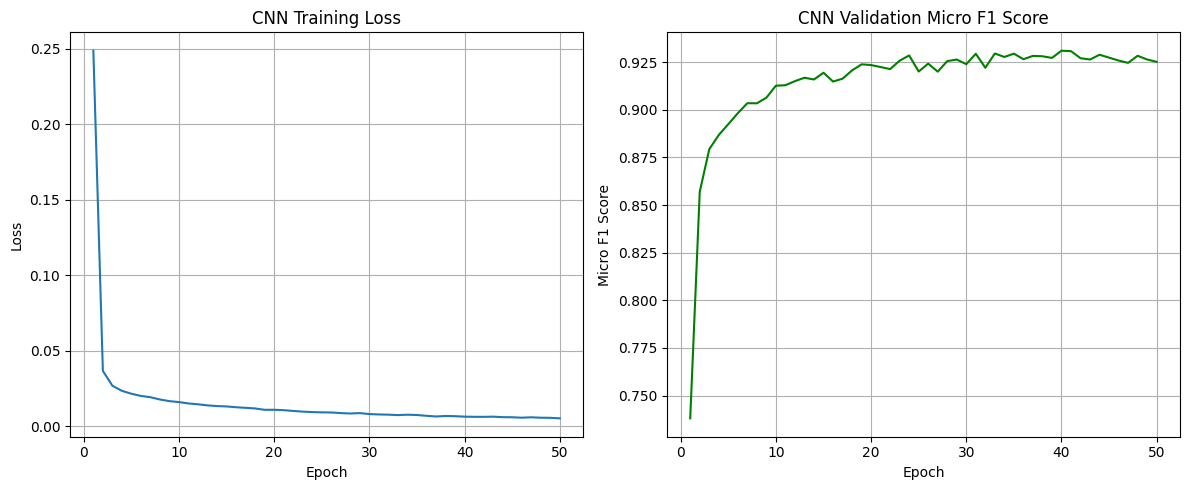

In [3]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load and preprocess data
amplitude_df = pd.read_csv("/kaggle/input/secound/all_signals_1.csv", header=None)
frequency_df = pd.read_csv("/kaggle/input/secound/all_frequencies_1.csv", header=None)

# Prepare amplitude input (X)
X = amplitude_df.iloc[:, 1:].values.astype(np.float32)
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)

# Prepare frequency labels (y)
y_raw = frequency_df.iloc[:, 1:].values
label_sets = [list(set(row[row != 0])) for row in y_raw]
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(label_sets)

# Tensor conversion
X_tensor = torch.tensor(X).unsqueeze(1)  # Shape: (N, 1, T)
y_tensor = torch.tensor(y).float()

# Dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Step 2: Define CNN model
class CNNClassifier(nn.Module):
    def __init__(self, input_length, num_labels):
        super(CNNClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.flatten_dim = (input_length // 4) * 64
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Instantiate model
model = CNNClassifier(input_length=X.shape[1], num_labels=y.shape[1])

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Training loop with F1 tracking
num_epochs = 50
cnn_losses = []
cnn_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    cnn_losses.append(avg_loss)

    # Validation F1-score
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            preds = (outputs > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='micro')
    cnn_f1_scores.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Micro F1: {f1:.4f}")

# Step 4: Final evaluation on validation set
model.eval()
final_preds = []
final_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = (outputs > 0.5).int()
        final_preds.extend(preds.cpu().numpy())
        final_labels.extend(labels.cpu().numpy())

final_f1 = f1_score(final_labels, final_preds, average='micro')
print(f"\nFinal Micro F1 Score: {final_f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(final_labels, final_preds, target_names=[str(l) for l in mlb.classes_]))

# Step 5: Plot Loss and F1 over epochs
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, cnn_losses, label="CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, cnn_f1_scores, label="CNN Val Micro F1", color="green")
plt.xlabel("Epoch")
plt.ylabel("Micro F1 Score")
plt.title("CNN Validation Micro F1 Score")
plt.grid(True)

plt.tight_layout()
plt.show()


In [4]:
import pandas as pd

model.eval()
all_preds = []
all_labels = []
comparison_rows = []

threshold = 0.5  # You can tune this

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        probs = outputs  # Already sigmoid from model
        preds = (probs > threshold).int()
        
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())
        
        # Record comparison
        for p, t in zip(preds, labels):
            pred_labels = [mlb.classes_[i] for i, val in enumerate(p) if val == 1]
            true_labels = [mlb.classes_[i] for i, val in enumerate(t) if val == 1]
            comparison_rows.append({
                "Predicted": pred_labels,
                "True": true_labels
            })

# Show F1 score
from sklearn.metrics import f1_score
f1 = f1_score(all_labels, all_preds, average='micro')
print(f"Micro F1 Score: {f1:.4f}")

# Convert comparisons to a DataFrame for easier viewing
comparison_df = pd.DataFrame(comparison_rows)
print(comparison_df.head(10))  # Show first 10 predictions and ground truths


comparison_df.to_csv("prediction_vs_ground_truth.csv", index=False)


Micro F1 Score: 0.9251
                                       Predicted  \
0                      [250, 350, 450, 550, 650]   
1                           [150, 250, 350, 450]   
2  [150, 250, 350, 450, 550, 667, 668, 750, 850]   
3                                [150, 250, 350]   
4                           [150, 250, 350, 450]   
5       [150, 250, 450, 550, 650, 750, 850, 950]   
6  [150, 250, 350, 450, 550, 650, 785, 850, 950]   
7                 [250, 350, 450, 550, 650, 750]   
8                 [150, 250, 350, 450, 550, 650]   
9       [150, 250, 350, 450, 550, 660, 750, 850]   

                                            True  
0                 [178, 250, 350, 450, 550, 650]  
1                           [150, 250, 350, 450]  
2       [150, 250, 350, 450, 550, 668, 750, 850]  
3                           [150, 250, 350, 460]  
4                      [150, 250, 350, 450, 550]  
5  [150, 250, 380, 450, 550, 650, 750, 850, 950]  
6  [150, 250, 350, 450, 550, 650, 786, 850, 950

In [5]:
import shutil

# Move CSV to /kaggle/working if it's not already there
shutil.move("prediction_vs_ground_truth.csv", "/kaggle/working/prediction_vs_ground_truth.csv")


'/kaggle/working/prediction_vs_ground_truth.csv'

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
import time

# ----------------------
# Training (CNN) — Track Time
# ----------------------
start_time = time.time()

for epoch in range(50):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/50, Loss: {total_loss / len(train_loader):.4f}")

end_time = time.time()
training_time_CNN = end_time - start_time
print(f"\n⏱️ Training Time (CNN): {training_time_CNN:.2f} seconds")


model.eval()
all_preds, all_labels = [], []

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # 5% error tolerance: allow some label mismatches
        total_labels = labels.size(1)
        mismatches = (preds != labels).sum(dim=1)  # per-sample mismatches
        allowed_errors = int(0.01*total_labels)

        correct += (mismatches <= allowed_errors).sum().item()
        total += labels.size(0)

# ----------------------
# Metrics
# ----------------------
f1_CNN = f1_score(all_labels, all_preds, average='micro')
accuracy_CNN = correct / total

print(f"\n✅ Micro F1 Score (CNN): {f1_CNN:.4f}")
print(f"🎯 Match Accuracy (≤1% Label Error): {accuracy_CNN:.4f}")
print(f"⏱️ Training Time (CNN): {training_time_CNN:.2f} seconds")

print("\n📋 Classification Report (CNN):\n", classification_report(all_labels, all_preds, target_names=[str(l) for l in mlb.classes_]))


Epoch 1/50, Loss: 0.0055
Epoch 2/50, Loss: 0.0055
Epoch 3/50, Loss: 0.0054
Epoch 4/50, Loss: 0.0051
Epoch 5/50, Loss: 0.0050
Epoch 6/50, Loss: 0.0051
Epoch 7/50, Loss: 0.0049
Epoch 8/50, Loss: 0.0048
Epoch 9/50, Loss: 0.0046
Epoch 10/50, Loss: 0.0049
Epoch 11/50, Loss: 0.0046
Epoch 12/50, Loss: 0.0043
Epoch 13/50, Loss: 0.0045
Epoch 14/50, Loss: 0.0043
Epoch 15/50, Loss: 0.0043
Epoch 16/50, Loss: 0.0043
Epoch 17/50, Loss: 0.0046
Epoch 18/50, Loss: 0.0044
Epoch 19/50, Loss: 0.0042
Epoch 20/50, Loss: 0.0040
Epoch 21/50, Loss: 0.0042
Epoch 22/50, Loss: 0.0042
Epoch 23/50, Loss: 0.0040
Epoch 24/50, Loss: 0.0040
Epoch 25/50, Loss: 0.0040
Epoch 26/50, Loss: 0.0039
Epoch 27/50, Loss: 0.0038
Epoch 28/50, Loss: 0.0038
Epoch 29/50, Loss: 0.0036
Epoch 30/50, Loss: 0.0036
Epoch 31/50, Loss: 0.0037
Epoch 32/50, Loss: 0.0033
Epoch 33/50, Loss: 0.0036
Epoch 34/50, Loss: 0.0034
Epoch 35/50, Loss: 0.0036
Epoch 36/50, Loss: 0.0036
Epoch 37/50, Loss: 0.0034
Epoch 38/50, Loss: 0.0032
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

Epoch 1/50, Loss: 0.1574, Val Micro F1: 0.7983
Epoch 2/50, Loss: 0.0473, Val Micro F1: 0.8205
Epoch 3/50, Loss: 0.0279, Val Micro F1: 0.8352
Epoch 4/50, Loss: 0.0254, Val Micro F1: 0.8409
Epoch 5/50, Loss: 0.0239, Val Micro F1: 0.8467
Epoch 6/50, Loss: 0.0231, Val Micro F1: 0.8495
Epoch 7/50, Loss: 0.0226, Val Micro F1: 0.8489
Epoch 8/50, Loss: 0.0217, Val Micro F1: 0.8525
Epoch 9/50, Loss: 0.0211, Val Micro F1: 0.8539
Epoch 10/50, Loss: 0.0204, Val Micro F1: 0.8582
Epoch 11/50, Loss: 0.0197, Val Micro F1: 0.8583
Epoch 12/50, Loss: 0.0190, Val Micro F1: 0.8586
Epoch 13/50, Loss: 0.0184, Val Micro F1: 0.8626
Epoch 14/50, Loss: 0.0174, Val Micro F1: 0.8663
Epoch 15/50, Loss: 0.0169, Val Micro F1: 0.8704
Epoch 16/50, Loss: 0.0158, Val Micro F1: 0.8797
Epoch 17/50, Loss: 0.0148, Val Micro F1: 0.8866
Epoch 18/50, Loss: 0.0135, Val Micro F1: 0.8906
Epoch 19/50, Loss: 0.0128, Val Micro F1: 0.8955
Epoch 20/50, Loss: 0.0117, Val Micro F1: 0.9036
Epoch 21/50, Loss: 0.0108, Val Micro F1: 0.9113
E

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

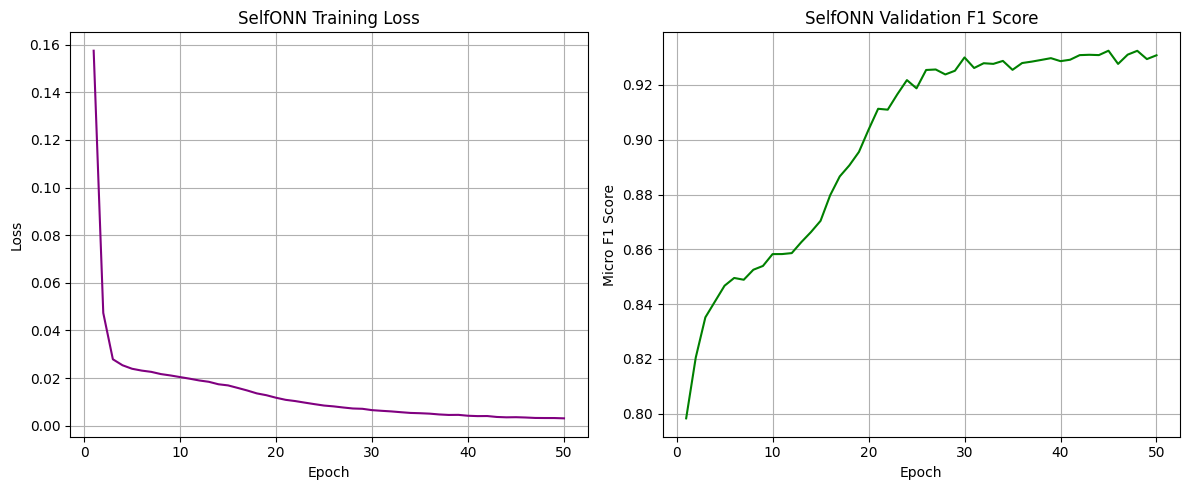

In [8]:
# 📦 Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 📂 Load Data
amplitude_df = pd.read_csv("/kaggle/input/secound/all_signals_1.csv", header=None)
frequency_df = pd.read_csv("/kaggle/input/secound/all_frequencies_1.csv", header=None)

# 🎛️ Preprocess Inputs (Amplitude)
X = amplitude_df.iloc[:, 1:].values.astype(np.float32)
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)

# 🎛️ Preprocess Labels (Frequency)
y_raw = frequency_df.iloc[:, 1:].values
label_sets = [list(set(row[row != 0])) for row in y_raw]

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(label_sets)

# 📦 Convert to Tensors
X_tensor = torch.tensor(X).unsqueeze(1)
y_tensor = torch.tensor(y).float()

# 📦 Create Dataset & Split
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# 🧱 SelfONN Layer Definition
class SelfONNLayer1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, order=3, stride=1, padding=0):
        super(SelfONNLayer1D, self).__init__()
        self.order = order
        self.weights = nn.ParameterList([
            nn.Parameter(torch.randn(out_channels, in_channels, kernel_size))
            for _ in range(order)
        ])
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        out = 0
        for k in range(self.order):
            out += nn.functional.conv1d(x ** (k + 1), self.weights[k], bias=None,
                                        stride=self.stride, padding=self.padding)
        out += self.bias.view(1, -1, 1)
        return out

# 🧱 SelfONN Classifier
class SelfONNClassifier(nn.Module):
    def __init__(self, input_length, num_labels, order=3):
        super(SelfONNClassifier, self).__init__()
        self.conv1 = SelfONNLayer1D(1, 32, kernel_size=5, order=order, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = SelfONNLayer1D(32, 64, kernel_size=3, order=order, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        flat_dim = (input_length // 4) * 64
        self.fc1 = nn.Linear(flat_dim, 256)
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(256, num_labels)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.drop(x)
        return torch.sigmoid(self.out(x))

# ⚙️ Instantiate Model
input_length = X.shape[1]
num_labels = y.shape[1]
model = SelfONNClassifier(input_length, num_labels, order=3)

# ⚙️ Loss & Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 📊 Lists for Loss & F1 Tracking
sonn_losses = []
sonn_f1_scores = []
num_epochs = 50

# 🏋️‍♂️ Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    sonn_losses.append(avg_loss)

    # 📏 Validation F1
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            preds = (outputs > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='micro')
    sonn_f1_scores.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Micro F1: {f1:.4f}")

# 📊 Final Evaluation
model.eval()
final_preds = []
final_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = (outputs > 0.5).int()
        final_preds.extend(preds.cpu().numpy())
        final_labels.extend(labels.cpu().numpy())

final_f1 = f1_score(final_labels, final_preds, average='micro')
print(f"\n✅ Final Micro F1 Score: {final_f1:.4f}")

# 📑 Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(final_labels, final_preds, target_names=[str(l) for l in mlb.classes_]))

# 📈 Plot Loss & F1
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, sonn_losses, label="Training Loss", color='purple')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SelfONN Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, sonn_f1_scores, label="Validation Micro F1", color='green')
plt.xlabel("Epoch")
plt.ylabel("Micro F1 Score")
plt.title("SelfONN Validation F1 Score")
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
import time

# ----------------------
# Training (SONN) — Track Time
# ----------------------
start_time = time.time()

for epoch in range(50):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/50, Loss: {total_loss / len(train_loader):.4f}")

end_time = time.time()
training_time_SONN = end_time - start_time
print(f"\n⏱️ Training Time (SONN): {training_time_SONN:.2f} seconds")

# ----------------------
# Evaluation (5% Label Error Tolerance)
# ----------------------
model.eval()
all_preds, all_labels = [], []

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # 5% error tolerance: allow some label mismatches
        total_labels = labels.size(1)
        mismatches = (preds != labels).sum(dim=1)
        allowed_errors = int(0.01 * total_labels)

        correct += (mismatches <= allowed_errors).sum().item()
        total += labels.size(0)

# ----------------------
# Metrics
# ----------------------
f1_SONN = f1_score(all_labels, all_preds, average='micro')
accuracy_SONN = correct / total

print(f"\n✅ Micro F1 Score (SONN): {f1_SONN:.4f}")
print(f"🎯 Match Accuracy (≤1% Label Error): {accuracy_SONN:.4f}")
print(f"⏱️ Training Time (SONN): {training_time_SONN:.2f} seconds")

print("\n📋 Classification Report (SONN):\n", classification_report(all_labels, all_preds, target_names=[str(l) for l in mlb.classes_]))


Epoch 1/50, Loss: 0.0028
Epoch 2/50, Loss: 0.0030
Epoch 3/50, Loss: 0.0028
Epoch 4/50, Loss: 0.0028
Epoch 5/50, Loss: 0.0028
Epoch 6/50, Loss: 0.0025
Epoch 7/50, Loss: 0.0025
Epoch 8/50, Loss: 0.0025
Epoch 9/50, Loss: 0.0024
Epoch 10/50, Loss: 0.0024
Epoch 11/50, Loss: 0.0022
Epoch 12/50, Loss: 0.0024
Epoch 13/50, Loss: 0.0021
Epoch 14/50, Loss: 0.0021
Epoch 15/50, Loss: 0.0020
Epoch 16/50, Loss: 0.0019
Epoch 17/50, Loss: 0.0019
Epoch 18/50, Loss: 0.0021
Epoch 19/50, Loss: 0.0021
Epoch 20/50, Loss: 0.0018
Epoch 21/50, Loss: 0.0017
Epoch 22/50, Loss: 0.0018
Epoch 23/50, Loss: 0.0017
Epoch 24/50, Loss: 0.0017
Epoch 25/50, Loss: 0.0016
Epoch 26/50, Loss: 0.0017
Epoch 27/50, Loss: 0.0015
Epoch 28/50, Loss: 0.0017
Epoch 29/50, Loss: 0.0017
Epoch 30/50, Loss: 0.0016
Epoch 31/50, Loss: 0.0016
Epoch 32/50, Loss: 0.0015
Epoch 33/50, Loss: 0.0019
Epoch 34/50, Loss: 0.0017
Epoch 35/50, Loss: 0.0015
Epoch 36/50, Loss: 0.0016
Epoch 37/50, Loss: 0.0015
Epoch 38/50, Loss: 0.0013
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

In [10]:
# pip install snntorch


In [11]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset, random_split
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.metrics import f1_score, classification_report
# import pandas as pd
# import numpy as np
# import snntorch as snn
# from snntorch import surrogate
# from snntorch import functional as SF

# # Load and normalize data
# amplitude_df = pd.read_csv("/kaggle/input/amplifreq/all_signals.csv", header=None)
# frequency_df = pd.read_csv("/kaggle/input/amplifreq/all_frequencies.csv", header=None)

# X = amplitude_df.iloc[:, 1:].values.astype(np.float32)
# X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)
# y_raw = frequency_df.iloc[:, 1:].values
# label_sets = [list(set(row[row != 0])) for row in y_raw]
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(label_sets)

# X_tensor = torch.tensor(X).unsqueeze(1)  # (B, C=1, T)
# y_tensor = torch.tensor(y).float()

# dataset = TensorDataset(X_tensor, y_tensor)
# train_size = int(0.8 * len(dataset))
# train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64)

# # SNN Classifier
# class SNNClassifier(nn.Module):
#     def __init__(self, input_length, num_labels, time_window=20):
#         super().__init__()
#         self.time_window = time_window
#         self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
#         self.lif1 = snn.Leaky(beta=0.95, spike_grad=surrogate.fast_sigmoid())

#         self.pool1 = nn.MaxPool1d(2)

#         self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
#         self.lif2 = snn.Leaky(beta=0.95, spike_grad=surrogate.fast_sigmoid())
#         self.pool2 = nn.MaxPool1d(2)

#         flat_dim = (input_length // 4) * 64
#         self.fc1 = nn.Linear(flat_dim, 256)
#         self.lif3 = snn.Leaky(beta=0.95, spike_grad=surrogate.fast_sigmoid())

#         self.fc2 = nn.Linear(256, num_labels)

#     def forward(self, x):
#         spk_rec = []
#         mem1 = mem2 = mem3 = 0

#         for step in range(self.time_window):
#             cur_input = x + torch.rand_like(x) * 0.01  # small noise simulating input variation

#             x1 = self.conv1(cur_input)
#             spk1, mem1 = self.lif1(x1, mem1)
#             x1 = self.pool1(spk1)

#             x2 = self.conv2(x1)
#             spk2, mem2 = self.lif2(x2, mem2)
#             x2 = self.pool2(spk2)

#             x2 = x2.view(x2.size(0), -1)
#             x3 = self.fc1(x2)
#             spk3, mem3 = self.lif3(x3, mem3)

#             out = self.fc2(spk3)
#             spk_rec.append(out)

#         spk_rec = torch.stack(spk_rec, dim=0)  # (time, batch, labels)
#         out_rate = spk_rec.mean(dim=0)  # firing rate
#         return torch.sigmoid(out_rate)

# # Instantiate model
# input_length = X.shape[1]
# num_labels = y.shape[1]
# model = SNNClassifier(input_length=input_length, num_labels=num_labels, time_window=20)

# # Training Setup
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training Loop
# for epoch in range(20):  # Reduce epochs due to longer simulation
#     model.train()
#     total_loss = 0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# # Evaluation
# model.eval()
# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for inputs, labels in val_loader:
#         outputs = model(inputs)
#         preds = (outputs > 0.5).int()
#         all_preds.extend(preds.numpy())
#         all_labels.extend(labels.numpy())

# f1 = f1_score(all_labels, all_preds, average='micro')
# print(f"Micro F1 Score: {f1:.4f}")
# print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=[str(l) for l in mlb.classes_]))


Epoch 01: Train Loss = 0.0842, Val Loss = 0.0260, Micro F1 = 0.8268
Epoch 02: Train Loss = 0.0236, Val Loss = 0.0205, Micro F1 = 0.8547
Epoch 03: Train Loss = 0.0182, Val Loss = 0.0189, Micro F1 = 0.8740
Epoch 04: Train Loss = 0.0153, Val Loss = 0.0180, Micro F1 = 0.8831
Epoch 05: Train Loss = 0.0128, Val Loss = 0.0172, Micro F1 = 0.8901
Epoch 06: Train Loss = 0.0107, Val Loss = 0.0168, Micro F1 = 0.8908
Epoch 07: Train Loss = 0.0089, Val Loss = 0.0168, Micro F1 = 0.8914
Epoch 08: Train Loss = 0.0072, Val Loss = 0.0164, Micro F1 = 0.8940
Epoch 09: Train Loss = 0.0062, Val Loss = 0.0160, Micro F1 = 0.8955
Epoch 10: Train Loss = 0.0049, Val Loss = 0.0162, Micro F1 = 0.8945
Epoch 11: Train Loss = 0.0041, Val Loss = 0.0161, Micro F1 = 0.8941
Epoch 12: Train Loss = 0.0033, Val Loss = 0.0160, Micro F1 = 0.8960
Epoch 13: Train Loss = 0.0031, Val Loss = 0.0167, Micro F1 = 0.8945
Epoch 14: Train Loss = 0.0026, Val Loss = 0.0171, Micro F1 = 0.9012
Epoch 15: Train Loss = 0.0022, Val Loss = 0.0173

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

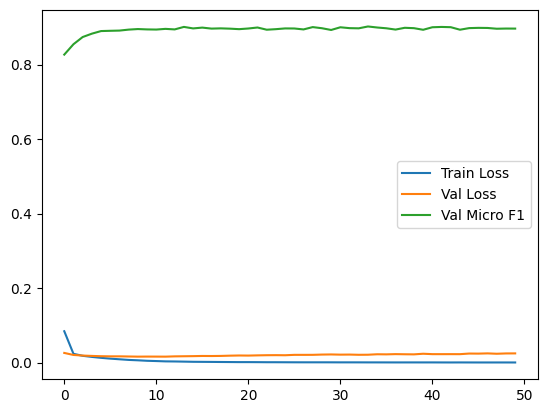

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import numpy as np

# ----------------------
# Load and preprocess data
# ----------------------
amplitude_df = pd.read_csv("/kaggle/input/secound/all_signals_1.csv", header=None)
frequency_df = pd.read_csv("/kaggle/input/secound/all_frequencies_1.csv", header=None)

X = amplitude_df.iloc[:, 1:].values.astype(np.float32)
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)

y_raw = frequency_df.iloc[:, 1:].values
label_sets = [list(set(row[row != 0])) for row in y_raw]
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(label_sets)

X_tensor = torch.tensor(X).unsqueeze(1)  # shape: [N, 1, T]
y_tensor = torch.tensor(y).float()

# Optionally reduce dataset size for memory reasons
X_tensor = X_tensor[:2000]
y_tensor = y_tensor[:2000]

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# ----------------------
# Define Spiking Neuron
# ----------------------
class LIFNeuron(nn.Module):
    def __init__(self, threshold=1.0, decay=0.9):
        super().__init__()
        self.threshold = threshold
        self.decay = decay

    def forward(self, x):
        batch_size, channels, time = x.size()
        mem = torch.zeros(batch_size, channels, device=x.device)
        spikes = []

        for t in range(time):
            input_t = x[:, :, t]
            mem = self.decay * mem + input_t
            spike = (mem >= self.threshold).float()
            mem = mem * (1 - spike)
            spikes.append(spike.unsqueeze(-1))

        return torch.cat(spikes, dim=-1)

# ----------------------
# SNN Model Definition
# ----------------------
class SNNClassifier(nn.Module):
    def __init__(self, input_length, num_labels):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.lif1 = LIFNeuron()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.lif2 = LIFNeuron()
        self.pool2 = nn.MaxPool1d(2)

        flat_dim = (input_length // 4) * 64
        self.fc1 = nn.Linear(flat_dim, 256)
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(256, num_labels)

    def forward(self, x):
        x = self.pool1(self.lif1(self.conv1(x)))
        x = self.pool2(self.lif2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.drop(x)
        return torch.sigmoid(self.out(x))

# ----------------------
# Train & Evaluate with Metrics Tracking
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_length = X_tensor.shape[2]
num_labels = y_tensor.shape[1]
model = SNNClassifier(input_length, num_labels).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
val_f1s = []

for epoch in range(50):
    model.train()
    total_train_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    f1 = f1_score(all_labels, all_preds, average='micro')
    val_f1s.append(f1)

    print(f"Epoch {epoch+1:02d}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Micro F1 = {f1:.4f}")

# ----------------------
# Final Classification Report
# ----------------------
print("\nFinal Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(l) for l in mlb.classes_]))

# Optionally plot losses & F1 (if needed)
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(val_f1s, label='Val Micro F1')
plt.legend()
plt.show()


In [14]:
amplitude_df.shape

(2000, 801)

In [15]:
import time

# ----------------------
# Training with time tracking
# ----------------------
start_time = time.time()

for epoch in range(50):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/50, Loss: {total_loss / len(train_loader):.4f}")

end_time = time.time()
training_time_SENN = end_time - start_time
print(f"\n⏱️ Training Time: {training_time_SENN:.2f} seconds")

# ----------------------
# Evaluation (5% Label Error Tolerance)
# ----------------------
model.eval()
all_preds, all_labels = [], []

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # 5% error tolerance: allow some label mismatches
        total_labels = labels.size(1)
        mismatches = (preds != labels).sum(dim=1)  # per-sample mismatches
        allowed_errors = int(0.01 * total_labels)

        correct += (mismatches <= allowed_errors).sum().item()
        total += labels.size(0)

# Micro F1 Score
f1_SENN = f1_score(all_labels, all_preds, average='micro')
accuracy_SENN = correct / total

print(f"\n✅ Micro F1 Score: {f1_SENN:.4f}")
print(f"🎯 Match Accuracy with ≤1% Label Error: {accuracy_SENN:.4f}")
print(f"⏱️ Training Time: {training_time_SENN:.2f} seconds")

print("\n📋 Classification Report:\n", classification_report(all_labels, all_preds, target_names=[str(l) for l in mlb.classes_]))


Epoch 1/50, Loss: 0.0003
Epoch 2/50, Loss: 0.0004
Epoch 3/50, Loss: 0.0003
Epoch 4/50, Loss: 0.0003
Epoch 5/50, Loss: 0.0003
Epoch 6/50, Loss: 0.0003
Epoch 7/50, Loss: 0.0004
Epoch 8/50, Loss: 0.0003
Epoch 9/50, Loss: 0.0003
Epoch 10/50, Loss: 0.0004
Epoch 11/50, Loss: 0.0003
Epoch 12/50, Loss: 0.0003
Epoch 13/50, Loss: 0.0003
Epoch 14/50, Loss: 0.0003
Epoch 15/50, Loss: 0.0003
Epoch 16/50, Loss: 0.0003
Epoch 17/50, Loss: 0.0003
Epoch 18/50, Loss: 0.0003
Epoch 19/50, Loss: 0.0003
Epoch 20/50, Loss: 0.0003
Epoch 21/50, Loss: 0.0003
Epoch 22/50, Loss: 0.0003
Epoch 23/50, Loss: 0.0003
Epoch 24/50, Loss: 0.0003
Epoch 25/50, Loss: 0.0003
Epoch 26/50, Loss: 0.0003
Epoch 27/50, Loss: 0.0003
Epoch 28/50, Loss: 0.0003
Epoch 29/50, Loss: 0.0004
Epoch 30/50, Loss: 0.0003
Epoch 31/50, Loss: 0.0003
Epoch 32/50, Loss: 0.0003
Epoch 33/50, Loss: 0.0003
Epoch 34/50, Loss: 0.0003
Epoch 35/50, Loss: 0.0003
Epoch 36/50, Loss: 0.0002
Epoch 37/50, Loss: 0.0003
Epoch 38/50, Loss: 0.0003
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import numpy as np

# ------------------------------
# 1. Load and Normalize Data
# ------------------------------
amplitude_df = pd.read_csv("/kaggle/input/secound/all_signals_1.csv", header=None)
frequency_df = pd.read_csv("/kaggle/input/secound/all_frequencies_1.csv", header=None)

X = amplitude_df.iloc[:, 1:].values.astype(np.float32)  # Skip timestamp column
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)

# ------------------------------
# 2. Pad/Truncate and Reshape to (N, 1, 128, 128)
# ------------------------------
target_len = 128 * 128
X_fixed = []

for row in X:
    if len(row) < target_len:
        padded = np.pad(row, (0, target_len - len(row)), mode='constant')
    else:
        padded = row[:target_len]
    X_fixed.append(padded)

X_fixed = np.array(X_fixed).reshape(-1, 1, 128, 128).astype(np.float32)

# ------------------------------
# 3. Prepare Multi-Label Targets
# ------------------------------
y_raw = frequency_df.iloc[:, 1:].values  # Skip timestamp column
label_sets = [list(set(row[row != 0])) for row in y_raw]

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(label_sets)

# ------------------------------
# 4. Create Datasets and Loaders
# ------------------------------
X_tensor = torch.tensor(X_fixed)
y_tensor = torch.tensor(y).float()

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# ------------------------------
# 5. Define CNN-based Multi-Label Classifier
# ------------------------------
class CNNFrequencyClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNFrequencyClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
            nn.Sigmoid()  # For multi-label classification
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = CNNFrequencyClassifier(num_classes=y.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ------------------------------
# 6. Training Loop
# ------------------------------
for epoch in range(10):  # You can increase if needed
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/10, Loss: {total_loss / len(train_loader):.4f}")

# ------------------------------
# 7. Evaluation
# ------------------------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = (outputs > 0.5).int()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1 = f1_score(all_labels, all_preds, average='micro')
print(f"\n✅ Micro F1 Score: {f1:.4f}")
print("\n📋 Classification Report:\n", classification_report(all_labels, all_preds, target_names=[str(l) for l in mlb.classes_]))


Epoch 1/10, Loss: 0.1361
Epoch 2/10, Loss: 0.0365
Epoch 3/10, Loss: 0.0338
Epoch 4/10, Loss: 0.0287
Epoch 5/10, Loss: 0.0262
Epoch 6/10, Loss: 0.0250
Epoch 7/10, Loss: 0.0243
Epoch 8/10, Loss: 0.0234
Epoch 9/10, Loss: 0.0227
Epoch 10/10, Loss: 0.0220

✅ Micro F1 Score: 0.8567

📋 Classification Report:
               precision    recall  f1-score   support

         150       0.91      0.98      0.94       309
         160       0.00      0.00      0.00         0
         161       0.00      0.00      0.00         1
         162       0.00      0.00      0.00         0
         163       0.00      0.00      0.00         1
         164       0.00      0.00      0.00         2
         165       0.00      0.00      0.00         2
         166       0.00      0.00      0.00         1
         167       0.00      0.00      0.00         2
         168       0.00      0.00      0.00         1
         169       0.00      0.00      0.00         2
         170       0.00      0.00      0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

In [18]:
import numpy as np
import pandas as pd

def run_topsis(df, weights, impacts):
    # Step 1: Prepare decision matrix (excluding the first column i.e., Model)
    decision_matrix = df.iloc[:, 1:].values
    
    # Step 2: Normalize the decision matrix (using vector normalization)
    norm_matrix = decision_matrix / np.linalg.norm(decision_matrix, axis=0)
    
    # Step 3: Apply weights
    weights = np.array(weights)
    weighted_matrix = norm_matrix * weights
    
    # Step 4: Determine ideal and negative-ideal solutions
    ideal = []
    negative_ideal = []
    for i, impact in enumerate(impacts):
        if impact == '+':
            ideal.append(np.max(weighted_matrix[:, i]))
            negative_ideal.append(np.min(weighted_matrix[:, i]))
        else:  # cost criterion
            ideal.append(np.min(weighted_matrix[:, i]))
            negative_ideal.append(np.max(weighted_matrix[:, i]))
    ideal = np.array(ideal)
    negative_ideal = np.array(negative_ideal)
    
    # Step 5: Compute Euclidean distances to ideal and negative-ideal
    dist_ideal = np.linalg.norm(weighted_matrix - ideal, axis=1)
    dist_negative = np.linalg.norm(weighted_matrix - negative_ideal, axis=1)
    
    # Step 6: Compute relative closeness to ideal solution
    closeness = dist_negative / (dist_ideal + dist_negative)
    
    # Step 7: Add TOPSIS score and rank to DataFrame
    df['TOPSIS Score'] = closeness
    df['Rank'] = df['TOPSIS Score'].rank(ascending=False).astype(int)
    
    # Step 8: Sort by Rank
    df = df.sort_values(by='TOPSIS Score', ascending=False).reset_index(drop=True)
    
    return df


# Example Data (replace these variables with your actual values)
accuracy_SONN = 0.89
accuracy_CNN = 0.91
accuracy_SENN = 0.87

f1_SONN = 0.88
f1_CNN = 0.90
f1_SENN = 0.86

data = {
    'Model': ['SelfONN', 'CNN', 'SNN'],
    'Accuracy': [accuracy_SONN, accuracy_CNN , accuracy_SENN],
    'F1 Score': [f1_SONN, f1_CNN , f1_SENN],          
}

df = pd.DataFrame(data)

# Define weights and impacts for 2 criteria now
weights = [0.6, 0.4]
impacts = ['+', '+']

# Run TOPSIS
result_df = run_topsis(df, weights, impacts)

# Show final result
print(result_df)


     Model  Accuracy  F1 Score  TOPSIS Score  Rank
0      CNN      0.91      0.90           1.0     1
1  SelfONN      0.89      0.88           0.5     2
2      SNN      0.87      0.86           0.0     3


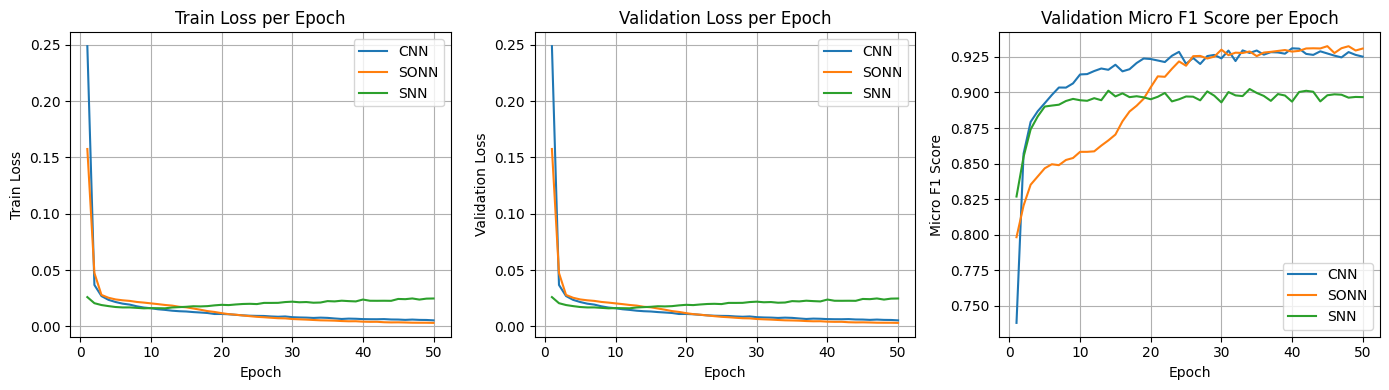

In [19]:
import matplotlib.pyplot as plt

# Example data — replace these with your actual logged lists per model
epochs = range(1, 51)  # assuming 50 epochs

# Dummy values (replace these)
modelA_train_losses = cnn_losses
modelA_val_losses   = cnn_losses
modelA_f1_scores    =  cnn_f1_scores

modelB_train_losses = sonn_losses
modelB_val_losses   = sonn_losses
modelB_f1_scores    = sonn_f1_scores

modelC_train_losses = val_losses
modelC_val_losses   = val_losses
modelC_f1_scores    = val_f1s

# 1️⃣ Train Loss Plot
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, modelA_train_losses, label='CNN')
plt.plot(epochs, modelB_train_losses, label='SONN')
plt.plot(epochs, modelC_train_losses, label='SNN')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss per Epoch')
plt.legend()
plt.grid(True)

# 2️⃣ Validation Loss Plot
plt.subplot(1, 3, 2)
plt.plot(epochs, modelA_val_losses, label='CNN')
plt.plot(epochs, modelB_val_losses, label='SONN')
plt.plot(epochs, modelC_val_losses, label='SNN')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss per Epoch')
plt.legend()
plt.grid(True)

# 3️⃣ Validation Accuracy / Micro F1 Plot
plt.subplot(1, 3, 3)
plt.plot(epochs, modelA_f1_scores, label='CNN')
plt.plot(epochs, modelB_f1_scores, label='SONN')
plt.plot(epochs, modelC_f1_scores, label='SNN')
plt.xlabel('Epoch')
plt.ylabel('Micro F1 Score')
plt.title('Validation Micro F1 Score per Epoch')
plt.legend()
plt.grid(True)

# Show full figure
plt.tight_layout()
plt.show()
